# DeepDream - PyTorch

We'll start by rewriting the deepdream code using PyTorch.
Once this will be done, we'll be able to play around with the training data in the network.

In [1]:
import math
import random
import tqdm
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd

from torchvision import models
from torchvision import transforms, utils
from torch.autograd import Variable

from PIL import Image
from scipy.ndimage.filters import gaussian_filter

In [2]:
torch.__version__

'1.4.0'

In [3]:
if torch.cuda.is_available():
    print("GPU found")
    device = "cuda:0"
else:
    device = "cpu"

GPU found


### Model

In [4]:
def construct_model(network, at_layer):
    layers = list(network.features.children())
    model = nn.Sequential(*layers[: (at_layer + 1)])
    if torch.cuda.is_available:
        model = model.cuda()
    return model

In [5]:
# Get very big convolutional network
network = models.vgg19(pretrained=True)
print(network)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### DeepDream Algorithm

#### Helpers function

In [6]:
# Helpers for images
def PIL_to_Tensor(image):
    loader = transforms.Compose([
        transforms.ToTensor()
    ])
    return loader(image).to(device)

def to_PIL(image: torch.Tensor):
    """
    Convert Tensor to PIL Image
    """
    return transforms.functional.to_pil_image(image.cpu())


def load_image(path: str):
    """
    Return a loaded image from a given path
    """
    image = Image.open(path)
    return image


def save_image(image, filename: str):
    """
    Save image 'image' at path 'filename'
    """
    # Convert Tensor into PIL Image if necessary
    if type(image) != Image.Image:
        image = to_PIL(image)
    with open(filename, 'wb') as file:
        image.save(filename, 'jpeg')
    
def plot_image(image: torch.Tensor):
    """
    Plot an image
    """
    # Convert Tensor to PIL Image if necessary
    if type(image) == torch.Tensor:
        image = to_PIL(image)
    display(image)

def resize(inputs, size: tuple=None, factor: float=None, interpolation='bilinear'):
    """
    Resize  an image given a target size

    :param inputs: Tensor, image
    :param size: tuple(int, int)
    :param interpolation: interpolation used
    :return: Tensor, resized image
    """
    model = torch.nn.Upsample(
        size=size,
        scale_factor=factor,
        mode=interpolation,
        align_corners=True
    ).to(device)
    return model(inputs)
    

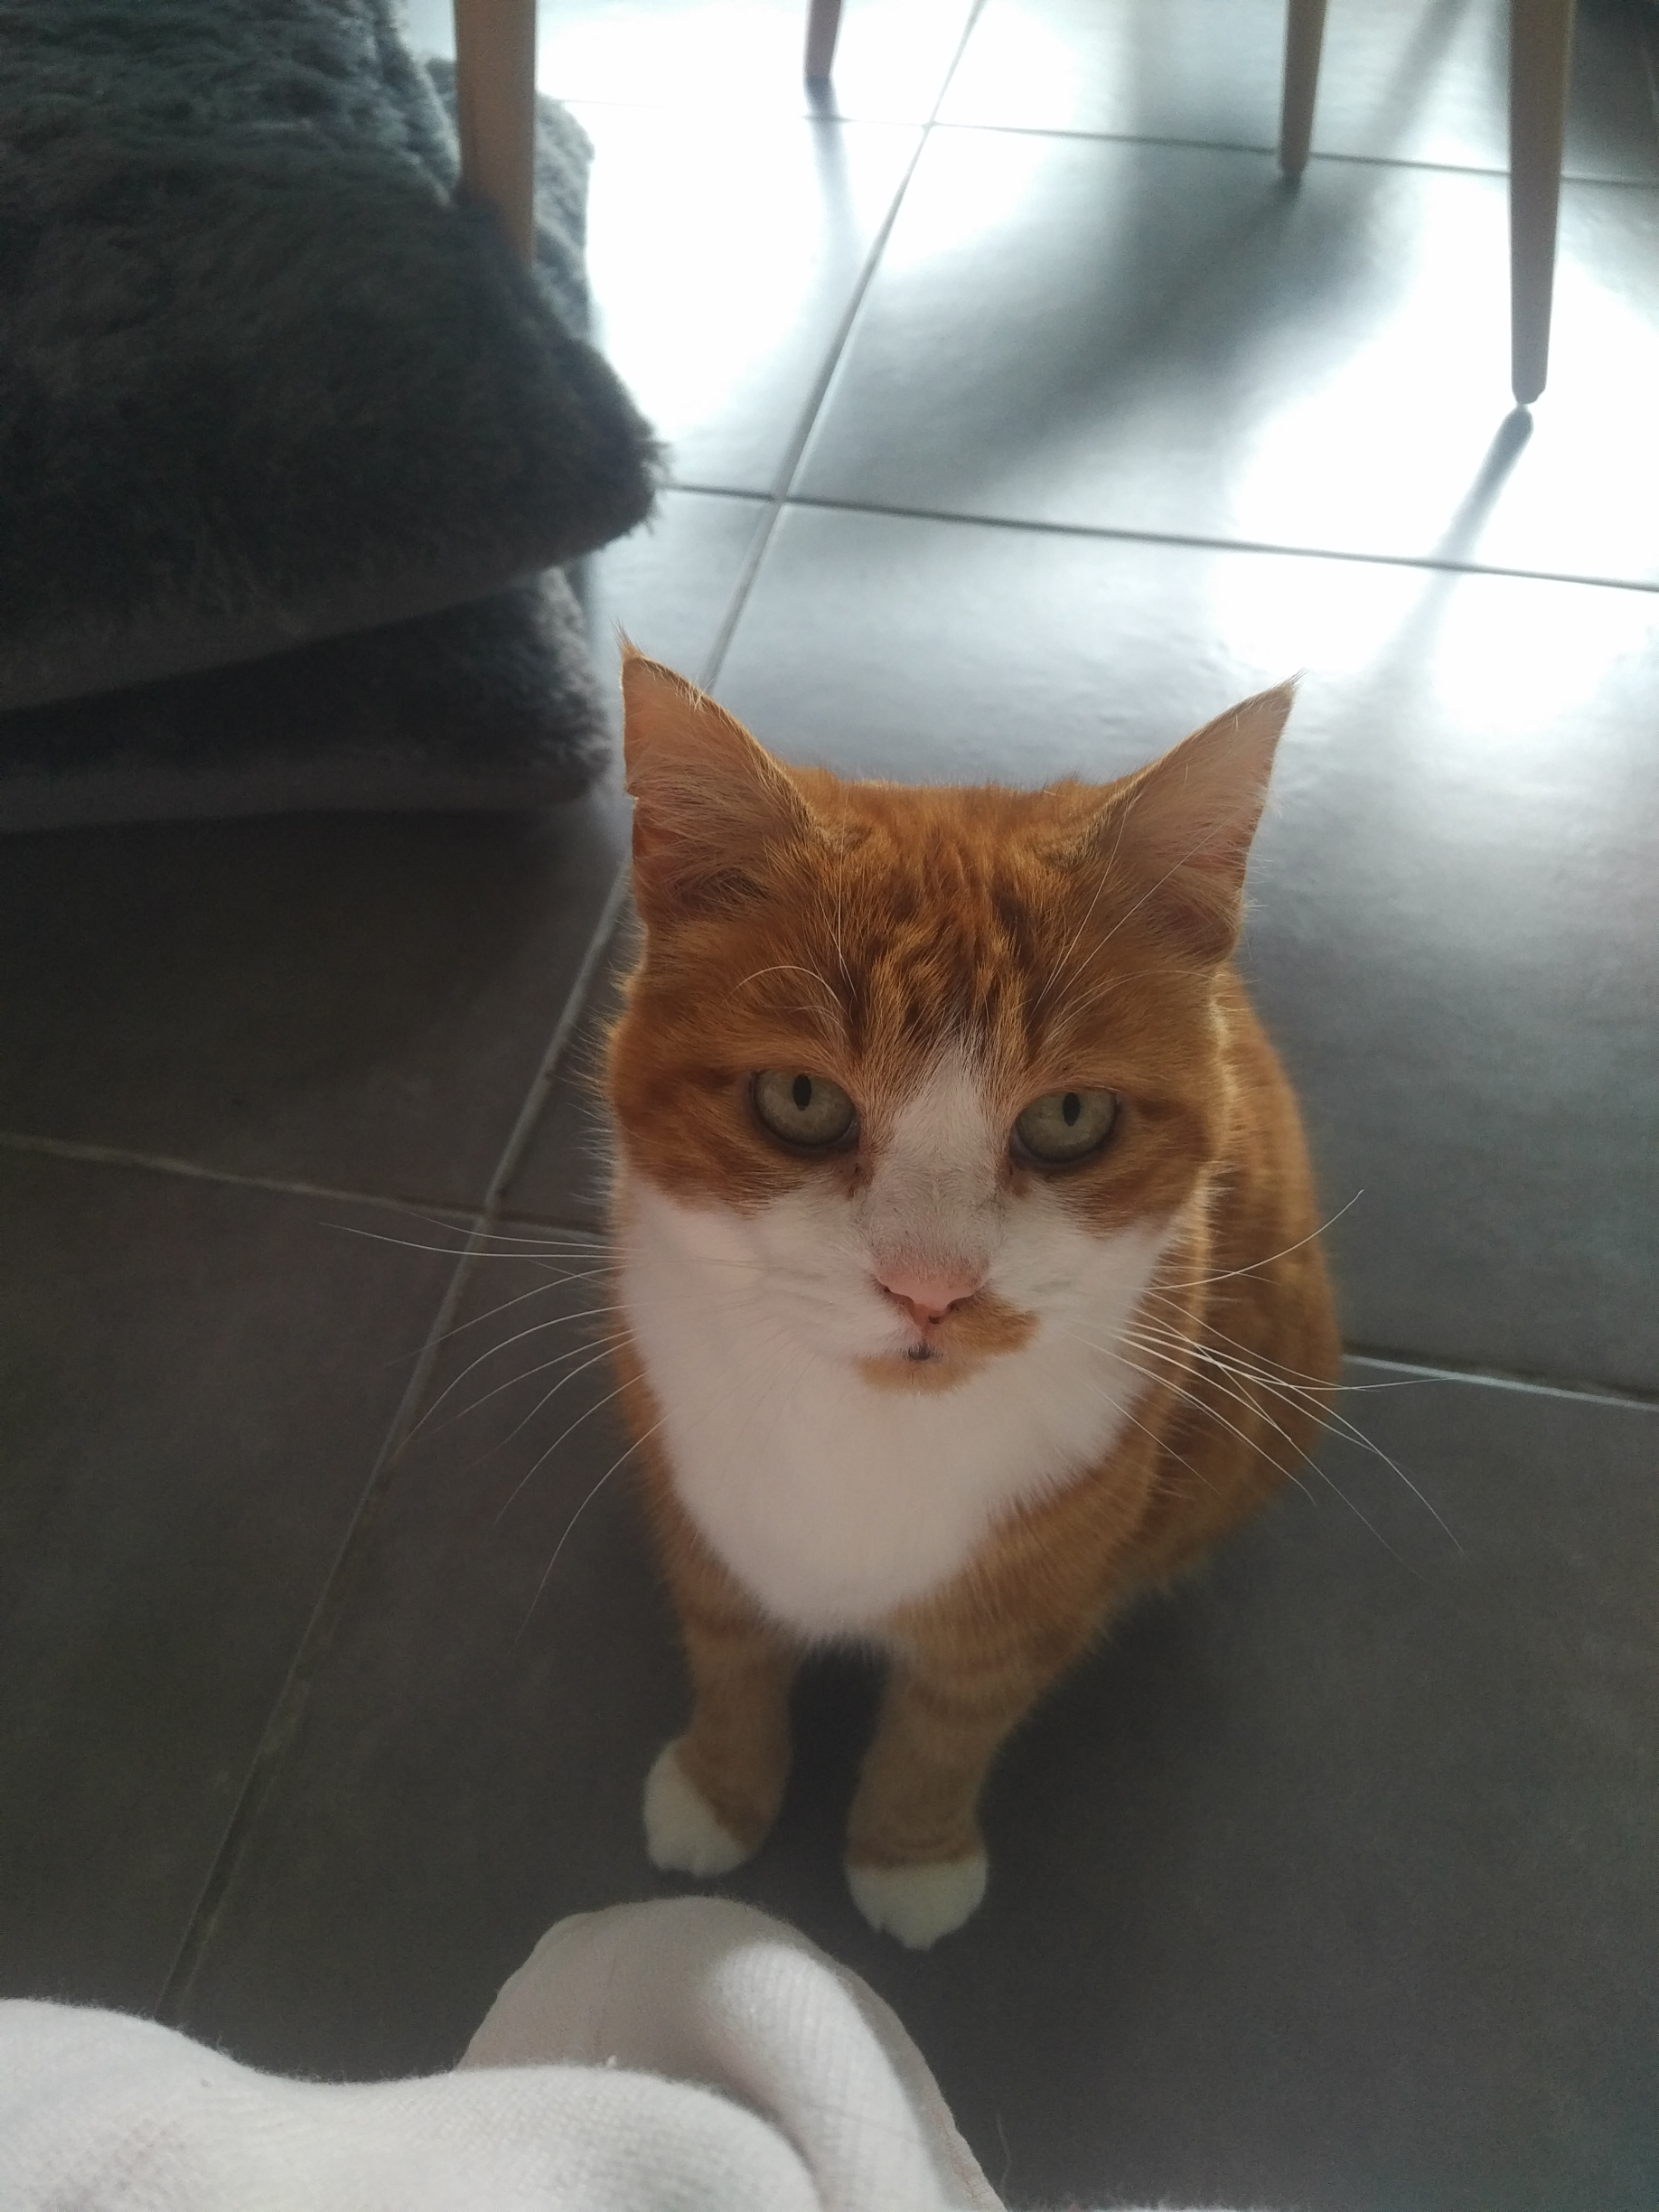

In [7]:
# Moral Boost Cat
cannelle = load_image('cannelle.jpg')
plot_image(resize(PIL_to_Tensor(cannelle).unsqueeze(0), factor=0.5).squeeze())

In [8]:
def clip(image_tensor, mean, std):
    for c in range(3):
        m, s = mean[c], std[c]
        image_tensor[0, c] = torch.clamp(image_tensor[0, c], -m / s, (1 - m) / s)
    return image_tensor


def deprocess(image, mean, std):
    image = image.squeeze() * std.reshape((3, 1, 1)) + mean.reshape((3, 1, 1))
    image = torch.clamp(image, min=0.0, max=1.0)
    return image


In [18]:
def dream(image, model, iterations, lr, mean, std):
    """
    Updates the image to maximize outputs for n iterations
    """
    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
    image = Variable(Tensor(image), requires_grad=True)
    for i in range(iterations):
        model.zero_grad()
        out = model(image)
        loss = out.norm()
        loss.backward()
        avg_grad = torch.abs(image.grad).mean()
        norm_lr = lr / avg_grad
        image.data += norm_lr * image.grad.data
        image.data = clip(image.data, mean, std)
        image.grad.data.zero_()
    return image

def deepdream(image, network, at_layer, iterations, lr, octave_scale, num_octaves, blend):
    """
    Main methode
    """
    model = construct_model(network, at_layer)
    
    image = PIL_to_Tensor(image)
    mean = image.mean(dim=[1,2])
    std = image.std(dim=[1,2])
    mean = torch.Tensor([0.485, 0.456, 0.406]).to(device)
    std = torch.Tensor([0.229, 0.224, 0.225]).to(device)
    image = to_PIL(image)

    preprocess = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
    image = preprocess(image).unsqueeze(0).to(device)
    
    octaves = [image]
    # Generate zoomed verion of the original image, and reapply to get more.
    for _ in range(num_octaves - 1):
        new_octave = resize(octaves[-1], factor=1/octave_scale)
        octaves.append(new_octave)

    detail = torch.zeros_like(octaves[-1]).to(device)
    for octave, octave_base in enumerate(octaves[::-1]):
        if octave > 0:
            # Upsample detail to new octave dimension
            detail = resize(detail, size=list(octave_base.size()[2:4]))

        # Add deep dream detail to new octave dimension
        input_image = octave_base + detail
        # Get new deep dream image
        dreamed_image = dream(input_image, model, iterations * (num_octaves - octave), lr, mean, std)
        # Extract deep dream details
        detail = dreamed_image - octave_base
        print("Octave: %2d / " % (octave+1), num_octaves)

    return deprocess(dreamed_image, mean, std)


In [13]:
image = load_image('cannelle.jpg')
print("Image Loaded.")

Image Loaded.


In [15]:
# Reduce size of image
image = PIL_to_Tensor(image).unsqueeze(0)
image = resize(image, factor=1/4)
image = to_PIL(image.squeeze())

In [ ]:
dreamed_image = deepdream(
    image,
    network,
    at_layer=18,
    iterations=20,
    lr=0.01,
    octave_scale=1.4,
    num_octaves=10,
# num_octaves = math.floor(math.log(min_dimension / 16) / math.log(octave_scale)),
    blend=0.8
)

Octave:  1 /  10
Octave:  2 /  10
Octave:  3 /  10
Octave:  4 /  10
Octave:  5 /  10
Octave:  6 /  10
Octave:  7 /  10
Octave:  8 /  10


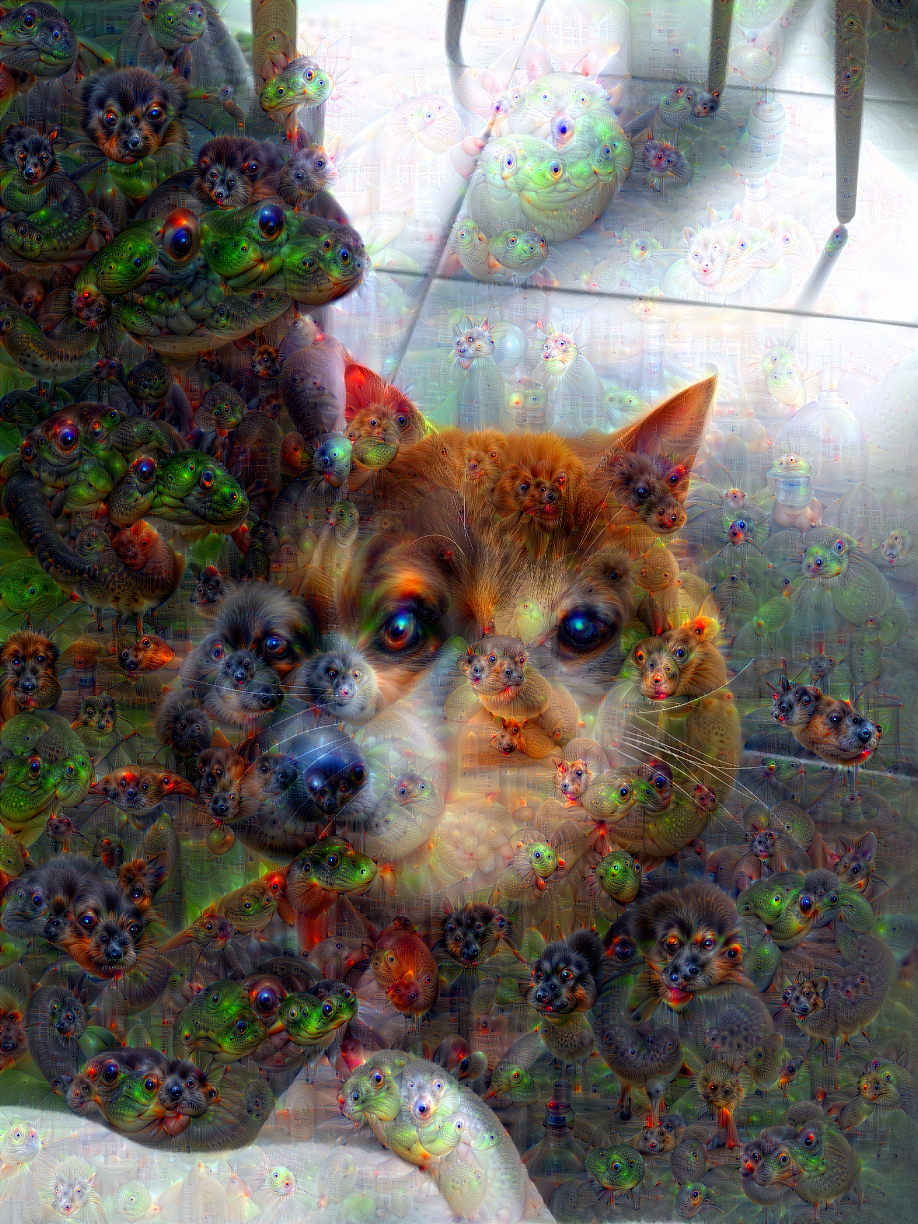

In [17]:
plot_image(dreamed_image.type(torch.float).squeeze())
save_image(dreamed_image, "dreamed_cannelle.jpg")